# Exercises
## Hartree-Fock
(sec:ci-exercises)=
## Configuration interaction
### One-particle density matrix

In this exercise, we are going to compute the one-particle density matrix for a CI wavefunction. The structure of the code is very similar to that of the energy, and actually, the energy can be computed directly from the one- and two-particle density matrix.

As a reminder, the density matrix (in molecular orbital basis) is defined in second quantization as:

\begin{equation*}
D_{pq} = \langle 0 | \hat{a}_p^\dagger \hat{a}_q | 0 \rangle
\end{equation*}

This is indeed very similar to the one-electron part of the $\sigma$ vector:

\begin{equation*}
\sigma^{(1)} = \sum_{pq} \hat{a}_p^\dagger \hat{a}_q | 0 \rangle h_{pq}
\end{equation*}

The difference then with the sigma algorithm is that instead of adding the $h_{ia}$ integral to the $\sigma$ vector, we store the product of the coefficients (`vector[idet]` and `vector[excdet.index()]`) in the "i,a" position of the density matrix. Note that the diagonal term $D_{pp}$ includes a loop over all occupied $\alpha$ and $\beta$ orbitals.

First let's initialize our calculations:

```python
import veloxchem as vlx
import multipsi as mtp
import numpy as np
O2_xyz="""2
O2                                                                                                                         
O    0.000000000000        0.000000000000       -0.600000000000 
O    0.000000000000        0.000000000000        0.600000000000 
"""

molecule = vlx.Molecule.from_xyz_string(O2_xyz)
basis = vlx.MolecularBasis.read(molecule,"STO-3G")

scfdrv = vlx.ScfRestrictedDriver()
scfdrv.compute(molecule, basis)

molecule.set_multiplicity(3)

space = mtp.OrbSpace(molecule,scfdrv.mol_orbs)
space.CAS(8,6)
expansion = mtp.CIExpansion(space)

CIdrv = mtp.CIDriver()
CIdrv.compute(molecule,basis,space)
```

Now let's implement the density matrix:

```python
def Den1(vector):
    DM = np.zeros((space.nAct,space.nAct))
    
    # Loop over determinants
    
    # Diagonal term
    
    # Single excitations alpha
    
    # Single excitations beta
    
    return DM
```

```python
#Check that the matrices match
vec0 = CIdrv.vecs[0].to_numpy()
Dpq = Den1(vec0)
np.testing.assert_almost_equal(Dpq, CIdrv.get1den(0))
```

### Several states

Modify the direct CI algorithm to compute several states (defined by a variable nstates). For this example we will use 3 states. We initialize the calculation with the same code as in the CI section:

```python
import veloxchem as vlx
import multipsi as mtp
import numpy as np
O2_xyz="""2
O2                                                                                                                         
O    0.000000000000        0.000000000000       -0.600000000000 
O    0.000000000000        0.000000000000        0.600000000000 
"""

molecule = vlx.Molecule.from_xyz_string(O2_xyz)
molecule.set_multiplicity(3)
basis = vlx.MolecularBasis.read(molecule,"STO-3G")

scfdrv = vlx.ScfUnrestrictedDriver()
scfdrv.compute(molecule, basis)

space = mtp.OrbSpace(molecule,scfdrv.mol_orbs)
space.FCI(nfrozen=4)

expansion=mtp.CIExpansion(space)
CIham = mtp.CIOperator(expansion) #Contains integrals and functions using them
CIham.compute_Hints(molecule,basis)

Ein = float(CIham.inEne)
Ftu = CIham.Ftu
tuvw = CIham.tuvw

def SC_diag(occa, occb):
    '''
    The energy of a given SD, as a function of its list of occupied orbitals
    '''
    Hij = Ein #Inactive energy (inc. nuclear repulsion)
    for i in occa:
        Hij += Ftu[i,i] #1-e term = inactive Fock matrix
        for j in occa:
            if i < j:
                Hij += tuvw[i,i,j,j] - tuvw[i,j,j,i] #Coulomb-Exchange
        for j in occb:
            Hij += tuvw[i,i,j,j]
    for i in occb:
        Hij += Ftu[i,i]
        for j in occb:
            if i < j:
                Hij += tuvw[i,i,j,j] - tuvw[i,j,j,i]
    return Hij
def SC_1exc(i,a,ss_occ, os_occ):
    '''
    Slater-Condon between a SD and a singly excited determinant, depending on the excited orbitals (i,a)
    and the same-spin (compared to spin of the excitated electron) and opposite-spin occupation
    '''
    Hij = Ftu[i,a]
    for k in ss_occ:
        Hij += tuvw[i,a,k,k]-tuvw[i,k,k,a]
    for k in os_occ:
        Hij += tuvw[i,a,k,k]
    return Hij
def SC_ss1exc(i,a,j,b):
    '''
    Slater-Condon between a SD and a doubly excited determinant,
    with both excited electrons having the same spin
    '''
    return tuvw[i,a,j,b]-tuvw[i,b,j,a]
def SC_os1exc(i,a,j,b):
    '''
    Slater-Condon between a SD and a doubly excited determinant,
    with the excited electrons having opposite spin
    '''
    return tuvw[i,a,j,b]

def sigma(vector):
    result = np.zeros(expansion.nDet)
    for idet, det in enumerate(expansion.detlist()):
        #Diagonal term
        result[idet] += SC_diag(det.occ_alpha(), det.occ_beta()) * vector[idet]
        #Single excitations alpha
        for i in det.occ_alpha():
            for a in det.unocc_alpha():
                phase, excdet = det.excite_alpha(i,a)
                result[excdet.index()] += phase * SC_1exc(i, a, det.occ_alpha(), det.occ_beta()) * vector[idet]
                #alpha-alpha excitation
                for j in det.occ_alpha():
                    if i >= j:
                        continue
                    for b in det.unocc_alpha():
                        if a >= b:
                            continue
                        phase2, exc2det=excdet.excite_alpha(j,b)
                        result[exc2det.index()] += phase * phase2 * SC_ss1exc(i,a,j,b) * vector[idet]
                #alpha-beta excitation
                for j in det.occ_beta():
                    for b in det.unocc_beta():
                        phase2, exc2det=excdet.excite_beta(j,b)
                        result[exc2det.index()] += phase * phase2 * SC_os1exc(i,a,j,b) * vector[idet]
        #Single excitations beta
        for i in det.occ_beta():
            for a in det.unocc_beta():
                phase, excdet = det.excite_beta(i,a)
                result[excdet.index()] += phase * SC_1exc(i, a, det.occ_beta(), det.occ_alpha()) * vector[idet]
                #beta-beta excitation
                for j in det.occ_beta():
                    if i >= j:
                        continue
                    for b in det.unocc_beta():
                        if a >= b:
                            continue
                        phase2, exc2det = excdet.excite_beta(j, b)
                        result[exc2det.index()] += phase * phase2 * SC_ss1exc(i,a,j,b) * vector[idet]
    return result

np.set_printoptions(formatter={'float_kind':"{:.3f}".format})

```

Hints:
* for the starting guess: to obtain the indices of the nstates lowest elements of a numpy array A, you can use the command:

```python
idx = np.argsort(A)[:nstates]
```

* for the most part, the difference is that we loop over nstates. The convergence is now based on the max of all residual norms. Finally, instead of only orthonormalizing with vec0, we need to make sure that all new vectors ("vec1") are orthogonal with all previous vectors ("vec0") and each others.

## MP2

In this block, you will implement the MP2 correction to the energy yourself, the $t$-amplitudes,
look at the dissociation of one hydrogen atom in the water molecule, and calculate the dipole moment at the MP2 level of theory.

First, we define the water molecule and a corresponding basis set and run the SCF calculation.

In [1]:
import veloxchem as vlx
import numpy as np
from matplotlib import pyplot as plt

* Warning * Environment variable OMP_NUM_THREADS not set.
* Warning * Setting OMP_NUM_THREADS to 8.
* Warning * Setting MKL_THREADING_LAYER to "GNU".


In [2]:
# Molecule and basis set
h2o_xyz = """3
water
O    0.000000000000        0.000000000000        0.000000000000                         
H    0.000000000000        0.895700000000       -0.316700000000                         
H    0.000000000000        0.000000000000        1.100000000000
"""

mol = vlx.Molecule.from_xyz_string(h2o_xyz)

basis = vlx.MolecularBasis.read(mol, "cc-pvdz")

In [3]:
# Run SCF
scfdrv = vlx.ScfRestrictedDriver()
scf_dict = {'conv_thresh': 1e-8}
scfdrv.update_settings(scf_dict)
scfdrv.compute(mol, basis)

                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Hartree-Fock                                         
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 50                                                                   
                   Max. Number of Error Vectors    : 10                                                                   
                

In [4]:
# Some of the following variables will be useful later

# Number of orbitals, orbital energies, MO coefficients, ERIs in spatial MO basis (physicists' notation)
N_MO = scfdrv.scf_tensors['C_alpha'].shape[1]
N_O = mol.number_of_electrons() // 2
N_V = N_MO - N_O
epsilon = scfdrv.scf_tensors["E"]
# epsilon_a - epsilon_i (as a 2D matrix)
epsilon_ov = epsilon[N_O:] - epsilon[:N_O].reshape(-1, 1)

# MO coefficients
C = scfdrv.scf_tensors["C"]
C_occ = C[:, :N_O]
C_vir = C[:, N_O:]

# ERI
moeridrv = vlx.MOIntegralsDriver()
eri_oovv = moeridrv.compute_in_mem(mol, basis, mol_orbs=scfdrv.mol_orbs, mints_type="OOVV")
eri_ooov = moeridrv.compute_in_mem(mol, basis, mol_orbs=scfdrv.mol_orbs, mints_type="OOOV")
eri_ovvv = moeridrv.compute_in_mem(mol, basis, mol_orbs=scfdrv.mol_orbs, mints_type="OVVV")

### Calculate the closed-shell MP2 energy correction

- Implement the MP2 energy correction using the following equation valid for the closed-shell restricted case in spatial orbitals:

  \begin{equation*}
    E_0^{(2)} = - \sum_{ijab} \frac{\langle ij | ab \rangle \langle ij | ab \rangle}{\varepsilon_a + \varepsilon_b - \varepsilon_i - \varepsilon_j}
    - \sum_{ijab} \frac{\langle ij | ab \rangle [ \langle ij | ab \rangle - \langle ij | ba \rangle]}{\varepsilon_a + \varepsilon_b - \varepsilon_i - \varepsilon_j} \, ,
  \end{equation*}
  where $\varepsilon_p$ are HF orbital energies and $\langle pq | rs \rangle$ are two-electron repulsion integrals in physicists' notation.
- The first term corresponds to the _opposite-spin_, the second one to the _same-spin_ contribution.

```python
def get_mp2_correction(molecule, basis, scfdrv):
    # initialize energy contributions to zero
    e_mp2_ss = 0.0
    e_mp2_os = 0.0

    # oovv integrals (spatial MO basis, physicists' notation)
    moeridrv = vlx.MOIntegralsDriver()
    oovv = moeridrv.compute_in_mem(molecule, basis, mol_orbs=scfdrv.mol_orbs, mints_type="OOVV")
  
    # extract the occupied subset of the orbital energies
    e_ij = scfdrv.scf_tensors["E"][:N_O]
    # extract the virtual subset of the orbital energies
    e_ab = scfdrv.scf_tensors["E"][N_O:]

    for i in range(N_O):
        for j in range(N_O):
            for a in range(N_V):
                for b in range(N_V):
                    # energy denominators
                    e_ijab =  ...
                    
                    # update opposite-spin component of the energy
                    e_mp2_os -= ...
                    
                    # update same-spin component of the energy
                    e_mp2_ss -= ...
    return e_mp2_ss, e_mp2_os

# calculate the energy correction
e_mp2_ss, e_mp2_os = get_mp2_correction(mol, basis, scfdrv)

# print and sum up the contributions
```

- Can you think of a way to make the calculation of $E_0^{(2)}$ more efficient by avoiding the last two for-loops over $a$ and $b$ by using matrix algebra from Python or numpy?

In [5]:
def get_mp2_correction(molecule, basis, scfdrv):
    e_mp2_ss = 0.0
    e_mp2_os = 0.0

    # oovv integrals (spatial MO basis, physicists' notation)
    moeridrv = vlx.MOIntegralsDriver()
    oovv = moeridrv.compute_in_mem(molecule, basis, mol_orbs=scfdrv.mol_orbs, mints_type="OOVV")
  
    # extract the occupied subset of the orbital energies
    e_occ = scfdrv.scf_tensors["E"][:N_O]
    # extract the virtual subset of the orbital energies
    e_vir = scfdrv.scf_tensors["E"][N_O:]
    e_ab = e_vir + e_vir.reshape(-1, 1) # epsilon_a + epsilon_b (as 2D matrix)
    
    for i in range(N_O):
        for j in range(N_O):
            e_mp2_os -= np.sum((oovv[i, j] * oovv[i, j]) / (e_ab - e_occ[i] - e_occ[j]))
            e_mp2_ss -= np.sum((oovv[i, j] * (oovv[i, j] - oovv[i, j].T)) / (e_ab - e_occ[i] - e_occ[j]))
    

    return e_mp2_ss, e_mp2_os

- Compare your results to the one from VeloxChem

```python
# MP2 calculation using Vlx
mp2driver = vlx.mp2driver.Mp2Driver()
mp2driver.compute(mol, basis, scfdrv.mol_orbs)
e_mp2_vlx = mp2driver.e_mp2

# calculate the (absolute) difference between the energy correction from Vlx and your own implementation
...
```

In [6]:
# MP2 calculation using Vlx
mp2driver = vlx.mp2driver.Mp2Driver()
mp2driver.ostream.state = False # turn off printing
mp2driver.compute(mol, basis, scfdrv.mol_orbs)
e_mp2_vlx = mp2driver.e_mp2

e_mp2_ss, e_mp2_os = get_mp2_correction(mol, basis, scfdrv)

print("\n\nComparison to native VeloxChem routine:\n")
print(f"Opposite-spin MP2 energy: {e_mp2_os:20.12f} H.")
print(f"Same-spin MP2 energy:     {e_mp2_ss:20.12f} H.")
print(f"MP2 energy:               {e_mp2_os + e_mp2_ss:20.12f} H.")
print(f"MP2 energy, vlx:          {e_mp2_vlx:20.12f} H.")



Comparison to native VeloxChem routine:

Opposite-spin MP2 energy:      -0.156069692863 H.
Same-spin MP2 energy:          -0.052034742400 H.
MP2 energy:                    -0.208104435264 H.
MP2 energy, vlx:               -0.208104435264 H.


(sec:calc-mp-t-amplitudes)=
### Calculate the MP2 amplitudes

The MP2 $t$-amplitudes, which are the [expansion coefficients](label:mp1-wf) of the first-order correction to the wave function and occur in many places,
are defined as:
\begin{align*}
t_{ijab} = \frac{\langle ij | ab \rangle - \langle ij | ba \rangle}{\varepsilon_a + \varepsilon_b - \varepsilon_i - \varepsilon_j}.
\end{align*}

In the following, we need to consider different spin blocks:
- For the $\alpha\alpha\alpha\alpha$ block, both integrals survive.
- For the $\alpha\beta\alpha\beta$ block, only the first ("Coulomb") integral survives.
- For the $\alpha\beta\beta\alpha$ block, only the second ("exchange") integral survives.

For a closed-shell system, the blocks with $\alpha$ and $\beta$ exchanged are identical and do not have to be calculated separately.

- Implement the three different spin blocks of the $t$ amplitudes.

```python
def get_t_amplitudes(molecule, basis, scfdrv):
     
    # orbital energies and oovv integrals (spatial MO basis, physicists' notation)
    moeridrv = vlx.MOIntegralsDriver()
    oovv = moeridrv.compute_in_mem(mol, basis, mol_orbs=scfdrv.mol_orbs, mints_type="OOVV")
     
    # extract the occupied subset of the orbital energies
    e_ij = scfdrv.scf_tensors["E"][:N_O]
    # extract the virtual subset of the orbital energies
    e_ab = scfdrv.scf_tensors["E"][N_O:]

    # initialize to zero (a=alpha, b=beta)
    t_aaaa = np.zeros((N_O, N_O, N_V, N_V))
    t_abab = np.zeros((N_O, N_O, N_V, N_V))
    t_abba = np.zeros((N_O, N_O, N_V, N_V))
    
    # calculate the t amplitudes using for-loops or numpy
    ...
                        
    # return a list/dictionary or similar with the different spin blocks                
    return ...
```

In [7]:
def get_t_amplitudes(molecule, basis, scfdrv):
    #t_aaaa, t_abab, t_abba
    #t_bbbb, t_baba, t_baab
     
    # orbital energies and oovv integrals (spatial MO basis, physicists' notation)
    moeridrv = vlx.MOIntegralsDriver()
    oovv = moeridrv.compute_in_mem(mol, basis, mol_orbs=scfdrv.mol_orbs, mints_type="OOVV")
     
    # extract the occupied subset of the orbital energies
    e_occ = scfdrv.scf_tensors["E"][:N_O]
    # extract the virtual subset of the orbital energies
    e_vir = scfdrv.scf_tensors["E"][N_O:]
    e_ab = e_vir + e_vir.reshape(-1, 1) # epsilon_a + epsilon_b (as 2D matrix)
          
    # Different spin blocks (a=alpha, b=beta)
    t2_aaaa = np.zeros((N_O, N_O, N_V, N_V))
    t2_abab = np.zeros((N_O, N_O, N_V, N_V))
    t2_abba = np.zeros((N_O, N_O, N_V, N_V))
    for i in range(N_O):
        for j in range(N_O):
            t2_aaaa[i,j] = (oovv[i, j] - eri_oovv[i, j].T) / (e_ab - e_occ[i] - e_occ[j])
            t2_abab[i,j] = (oovv[i, j]) / (e_ab - e_occ[i] - e_occ[j])
            t2_abba[j,i] = (- eri_oovv[j, i].T) / (e_ab - e_occ[i] - e_occ[j])
            
    t2_mp2 = {'aaaa': t2_aaaa, 'abab': t2_abab, 'abba': t2_abba}

    return t2_mp2

### Calculate the MP2 energy correction using the $t$ amplitudes

The MP2 energy correction can also be calculated in spin orbitals by using the $t$ amplitudes as:
\begin{equation*}
E_0^{(2)} = -\frac14\sum_{ijab} t_{ijab} \big( \langle ij | ab \rangle - \langle ij | ba \rangle \big).
\end{equation*}

- Use your function to get the $t$ amplitudes and use them to calculate the MP2 energy correction.
- Remember that you use spatial orbitals, so take care of the different spin blocks (which integrals survive?).
- You only have $\alpha$ spin blocks, but the corresponding $\beta$ blocks are identical.
- Check again that you get the correct result.

```python
# get t amplitudes
t2 = ...
# calculate energy correction
e_mp2 = ...
```

In [8]:
t2 = get_t_amplitudes(mol, basis, scfdrv)

e_mp2 = -0.5*( np.einsum('ijab,ijab->', t2['aaaa'], eri_oovv)
          -np.einsum('ijab,ijba->', t2['aaaa'], eri_oovv)
          +np.einsum('ijab,ijab->', t2['abab'], eri_oovv)
          -np.einsum('ijab,ijba->', t2['abba'], eri_oovv) )

print("\nComparison to MP2 using same-spin, opposite-spin, and native VeloxChem routine:\n")
print(f"MP2 energy, t-amplitudes: {e_mp2:20.12f} H.")
print(f"MP2 energy:               {e_mp2_os + e_mp2_ss:20.12f} H.")
print(f"MP2 energy, vlx:          {e_mp2_vlx:20.12f} H.")


Comparison to MP2 using same-spin, opposite-spin, and native VeloxChem routine:

MP2 energy, t-amplitudes:      -0.208104435264 H.
MP2 energy:                    -0.208104435264 H.
MP2 energy, vlx:               -0.208104435264 H.


### O--H dissociation potential energy curve

We want to look at the dissociation of one hydrogen atom in the water molecule.
MP2 represents a significant improvement over the HF energy around the equilibrium bond length.
At longer bond lengths, however, some occupied and virtual orbitals become closer in energy to each other.
This makes the orbital-energy denominator of the MP2 correction smaller, and hence $E_0^{(2)}$ larger and larger (in magnitude). 
The correlation energy will thus be overestimated at some point and the dissociation curve will become non-physical.

- Take the following molecule template and calculate the MP2 energy for a series of different bond lengths
- Plot the potential energy curve for RHF and MP2

```python
mol_template = """                                                                                                              
O    0.000000000000        0.000000000000        0.000000000000                         
H    0.000000000000        0.895700000000       -0.316700000000                         
H    0.000000000000        0.000000000000        OHdist
"""

# list of bond distances
distlist = [0.7,0.75,0.8,0.85,0.9,0.95,1.0,1.05,1.1,1.3,1.5,1.7,2,2.5,3,3.4,4.1,4.5]

# Empty list for HF and MP2 energies
E_hf = []
E_mp2 = []

# SCF driver
scfdrv_pec = vlx.ScfRestrictedDriver()
scfdrv_pec.max_iter = 100 # maximum number of iterations
#scfdrv_pec.ostream.state = False # To disable the printout
for oh in distlist:
    print("Calculating the energies for... ", oh)
    
    # Create new molecule
    mol_str = mol_template.replace("OHdist", str(oh))
    molecule = vlx.Molecule.read_str(mol_str, units='angstrom')
    basis = vlx.MolecularBasis.read(molecule,"cc-pvdz")
    
    # Compute SCF energy
    ...
    E_hf.append(scfdrv_pec.get_scf_energy())
    
    # Compute MP2 energy
    e_mp2_ss, e_mp2_os = ...
    E_mp2.append(scfdrv_pec.get_scf_energy() + e_mp2_ss + e_mp2_os)
    
# Plot the results    
plt.figure(figsize=(6,4))
plt.title('Energy during O-H dissociation')
x = np.array(distlist)
y = np.array(E_mp2)
z = np.array(E_hf)
plt.plot(x,y, label='MP2')
plt.plot(x,z, label='RHF')
plt.legend()
plt.tight_layout(); plt.show()
```

- You can compare these curves to the [FCI result](sec:static-correlation)

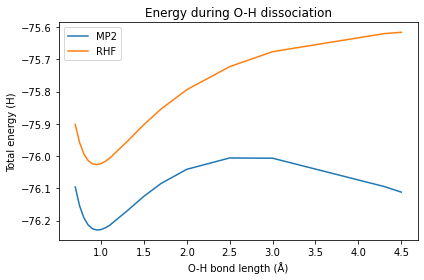

In [9]:
mol_template = """                                                                                                              
O    0.000000000000        0.000000000000        0.000000000000                         
H    0.000000000000        0.895700000000       -0.316700000000                         
H    0.000000000000        0.000000000000        OHdist
"""

# list of bond distances
distlist = [0.7,0.75,0.8,0.85,0.9,0.95,1.0,1.05,1.1,1.3,1.5,1.7,2,2.5,3,4.3,4.5]

# empty list for HF and MP2 energies
E_hf = []
E_mp2 = []

# SCF driver
scfdrv_pec = vlx.ScfRestrictedDriver()
scfdrv_pec.ostream.state = False # To disable the printout
for oh in distlist:
    # Create new molecule
    mol_str = mol_template.replace("OHdist", str(oh))
    molecule = vlx.Molecule.read_str(mol_str, units='angstrom')
    basis = vlx.MolecularBasis.read(molecule,"cc-pvdz")
    
    # Compute SCF energy
    scfdrv_pec.compute(molecule, basis)
    E_hf.append(scfdrv_pec.get_scf_energy())
    
    #print("Calculating the energies for... %5.2f" % oh, " Å; converged? ", scfdrv_pec.is_converged)
    
    # Compute MP2 energy
    e_mp2_ss, e_mp2_os = get_mp2_correction(molecule, basis, scfdrv_pec)
    E_mp2.append(scfdrv_pec.get_scf_energy() + e_mp2_ss + e_mp2_os)

# Plot the results
plt.figure(figsize=(6,4))
plt.title('Energy during O-H dissociation')
x = np.array(distlist)
y = np.array(E_mp2)
z = np.array(E_hf)

plt.plot(x,y, label='MP2')
plt.plot(x,z, label='RHF')
plt.xlabel('O-H bond length (Å)')
plt.ylabel('Total energy (H)')

plt.legend()
plt.tight_layout(); plt.show()

### Dipole moment

One often wants to characterize molecular systems beyond pure energetics.
As an example of another basic property, we look at the electric dipole moment $\boldsymbol{\mu}$, which is an important factor for long-range interaction between different molecules.
The dipole moment $\boldsymbol{\mu}$ is an example of a [first-order property](sec:first-order-prop),
which can be calculated as a derivative of the energy with respect to an external electric field $\boldsymbol{\mathcal{F}}$.
As such, it can be calculated either [numerically](sec:numerical-gradients) or [analytically](sec:analytical-gradients).
In the latter case, the calculation of the electronic contribution to $\boldsymbol{\mu}$ is given by the contraction of the one-particle density matrix $\boldsymbol{\gamma}$ with the dipole integrals ($\mu_{\kappa \lambda}$), either in the atomic-orbital (AO) or molecular-orbital (MO) basis.
Denoting MO indices with Latin letters and AO indices with Greek ones, this equivalence can be expressed as
\begin{equation*}
  \boldsymbol{\mu} = \sum_{pq} \gamma_{pq} \, \mu_{qp} = \sum_{\kappa \lambda} \gamma_{\kappa \lambda} \, \mu_{\lambda \kappa}
\end{equation*}

In order to avoid having to transform all property integrals to MO basis, one usually transforms the density matrix to AO:
\begin{equation*}
  \gamma_{\kappa \lambda} = \sum_{pq} C_{\kappa p} \, \gamma_{pq} \, C_{\lambda q}
\end{equation*}

In the following, we want to look at the dipole moment calculated with different approximation schemes.

#### HF dipole moment

In order to obtain the dipole moment at the HF level, we only have to get the total (zeroth-order) SCF density $\boldsymbol{\gamma}^{(0)}$ and provide it to the `FirstOrderProperties` driver, which takes care of the rest (contraction with the dipole integrals and adding the nuclear contribution).

In [10]:
scf_density = 2 * scfdrv.scf_tensors['D_alpha'] # factor 2 for alpha+beta density
prop = vlx.firstorderprop.FirstOrderProperties()
prop.compute(mol, basis, scf_density)
hf_dipole_moment = prop.get_property('dipole moment')
prop.print_properties(mol, 'HF dipole moment')

                                                                                                                          
                                                     HF dipole moment                                                     
                                                    ------------------                                                    
                                                                                                                          
                                   X   :         0.000000 a.u.         0.000000 Debye                                     
                                   Y   :         0.627759 a.u.         1.595604 Debye                                     
                                   Z   :         0.498104 a.u.         1.266055 Debye                                     
                                 Total :         0.801367 a.u.         2.036872 Debye                                     
                

This piece of code can be reused for the calculation of dipole moments, only the corresponding total density matrix needs to be changed.

(sec:unrel-mp2-dipole)=
#### Unrelaxed MP2 dipole moment

At the MP2 level, additional contributions to all blocks (occupied-occupied, virtual-virtual, and occupied-virtual) of the one-particle density matrix need to be taken into account.
The occupied-virtual block of the MP2 density matrix is related to orbital relaxation due to the perturbation
and has to be calculated iteratively (for more details, see [here](sec:mp2-gradients)).
The occupied-occupied and virtual-virtual blocks of the second-order correction to the ground-state one-particle density matrix, on the other hand, can directly be calculated from the $t$-amplitudes as
\begin{align*}
  \gamma_{ij}^{(2)} &= -\frac12 \sum_{kab} t_{ikab} \, t_{jkab} \\
  \gamma_{ab}^{(2)} &= +\frac12 \sum_{ijc} t_{ijac} \, t_{ijbc}
\end{align*}

Considering only these two blocks (and hence neglecting orbital relaxation effects) is often referred to as the _unrelaxed density matrix_
and properties calculated with it as (orbital) unrelaxed.

- Implement the two blocks of the second-order correction $\boldsymbol{\gamma}^{(2)}$ to the one-particle density matrix.
- Transform them from the MO to the AO basis.
- Add this density to the SCF density and calculate the dipole moment again.

```{note}
- Remember that there are different spin blocks in $t_{ijab}$
```

```python
# occ-occ block
gamma_ij = ...

# vir-vir block
gamma_ab = ...

# Transform to AO basis
gamma_ao = ...

# Add SCF density and calculate dipole moment
unrelaxed_density = ...
# Compute property with density
...
# Get the unrelaxed dipole moment
ur_mp2_dipole_moment = ...
# Print it
prop.print_properties(molecule, 'Unrelaxed MP2 dipole moment')
```

In [11]:
# occ-occ block
gamma_ij = - (np.einsum('ikab,jkab->ij', t2['aaaa'], t2['aaaa']) + np.einsum('ikab,jkab->ij', t2['abab'], t2['abab']) + np.einsum('ikab,jkab->ij', t2['abba'], t2['abba']))

# vir-vir block
gamma_ab = np.einsum('ijac,ijbc->ab', t2['aaaa'], t2['aaaa']) + np.einsum('ijac,ijbc->ab', t2['abab'], t2['abab']) + np.einsum('ijac,ijbc->ab', t2['abba'], t2['abba'])

# Transform to AO basis
gamma_ao = np.linalg.multi_dot([C_occ, gamma_ij, C_occ.T]) + np.linalg.multi_dot([C_vir, gamma_ab, C_vir.T])

# Add SCF density and calculate dipole moment
unrelaxed_density = scf_density + gamma_ao
prop.compute(mol, basis, unrelaxed_density)
ur_mp2_dipole_moment = prop.get_property('dipole moment')
prop.print_properties(molecule, 'Unrelaxed MP2 dipole moment')

                                                                                                                          
                                               Unrelaxed MP2 dipole moment                                                
                                              -----------------------------                                               
                                                                                                                          
                                   X   :         0.000000 a.u.         0.000000 Debye                                     
                                   Y   :         0.620980 a.u.         1.578373 Debye                                     
                                   Z   :         0.488613 a.u.         1.241931 Debye                                     
                                 Total :         0.790164 a.u.         2.008396 Debye                                     
                

#### Approximate relaxed MP2 dipole moment

- In order to calculate the [gradient of the MP2 energy analytically](sec:mp2-gradients), orbital response equations need to be solved iteratively
in order to obtain the occupied-virtual block of the one-particle density matrix.
- As an approximation to that, the following equation (in spin orbitals) can be used,
\begin{equation*}
  \lambda_{ia} = \frac{1}{\varepsilon_{a} - \varepsilon_{i}} \bigg[ \frac12 \sum_{jkb} t_{jkab} \langle jk || ib \rangle + \frac12 \sum_{jbc} t_{ijbc} \langle ja || bc \rangle \bigg].
\end{equation*}

- For the closed-shell restricted case, the above equation can be written in spatial orbitals as,
\begin{align*}
  \lambda_{ia} &= \frac{1}{\varepsilon_{a} - \varepsilon_{i}} \bigg[ \sum_{jbc} \frac{\langle ij | bc \rangle}{\varepsilon_b + \varepsilon_c - \varepsilon_i - \varepsilon_j} \big( 2 \langle ja | cb \rangle - \langle ja | bc \rangle \big) \\
  &\ \ - \sum_{jkb} \frac{\langle jk | ab \rangle}{\varepsilon_a + \varepsilon_b - \varepsilon_j - \varepsilon_k} \big( 2 \langle jk | ib \rangle - \langle kj | ib \rangle \big) \bigg].
\end{align*}

```{note}
- Note that the "$t$-amplitudes" in the closed-shell equation above (without anti-symmetrized integrals) correspond to the $\alpha\beta\alpha\beta$ block of the normal ones
- Both the occ-vir and vir-occ blocks of $\boldsymbol{\lambda}$ are needed, but one is the transpose of the other
```

```python
# Calculate the first term
term1 = 2 * np.einsum('ijbc,jacb->ia', t2['abab'], eri_ovvv) - ...

# Calculate the second term
term2 = ...

# Calculate lambda (sum up the two terms and divide by orbital-energy difference)
lambda_ov = ...

# Transform lambda to AO (both the ov and the vo blocks)
lambda_ao = ...

# Compute the approximate relaxed dipole moment by adding lambda (alpha+beta) to the density
...
# Get the approximate relaxed dipole moment
rel_mp2_dipole_moment = ...
prop.print_properties(mol, 'Approx. relaxed MP2 dipole moment')
```

In [12]:
term1 = -(2 * np.einsum('jkab,jkib->ia', t2['abab'], eri_ooov)
            - np.einsum('jkab,kjib->ia', t2['abab'], eri_ooov)
         )
term2 = (2 * np.einsum('ijbc,jacb->ia', t2['abab'], eri_ovvv)
           - np.einsum('ijbc,jabc->ia', t2['abab'], eri_ovvv)
         )

lambda_ov = (term1 + term2) / epsilon_ov

lambda_ao = ( np.linalg.multi_dot([C_occ, lambda_ov, C_vir.T])
            + np.linalg.multi_dot([C_vir, lambda_ov.T, C_occ.T])
            )

prop.compute(mol, basis, unrelaxed_density + 2 * lambda_ao)
rel_mp2_dipole_moment = prop.get_property('dipole moment')
prop.print_properties(mol, 'Approx. relaxed MP2 dipole moment')

                                                                                                                          
                                            Approx. relaxed MP2 dipole moment                                             
                                           -----------------------------------                                            
                                                                                                                          
                                   X   :         0.000000 a.u.         0.000000 Debye                                     
                                   Y   :         0.601516 a.u.         1.528902 Debye                                     
                                   Z   :         0.465020 a.u.         1.181962 Debye                                     
                                 Total :         0.760306 a.u.         1.932505 Debye                                     
                

#### Numerical HF and MP2 dipole moment

- Calculate the $z$ component of the dipole moment as a numerical derivative with respect to an external electric field $\mathcal{F}_z$ at the HF and MP2 levels.
- Apply an electric field in $z$ direction with a strength of $\mathcal{F}_z = 10^{-5}$ a.u. for the SCF calculation, then calculate the MP2 energy with that result.
- Then the dipole moment $\mu_z$
can be calculated approximately as,

$$
  \mu_z = -\frac{\Delta E}{\Delta \mathcal{F}_z} = -\frac{E(\mathcal{F}_z) - E(-\mathcal{F}_z)}{2 \mathcal{F}_z}.
$$

```python
# SCF driver for positive field direction
scfdrv_p = vlx.ScfRestrictedDriver()
# Define external electric field
method_dict_p = {'electric_field': '0,0,0.00001'}
# Update the settings with the electric field
scfdrv_p.update_settings(scf_dict, method_dict_p)
# Compute SCF energy in presence of external field
scfdrv_p.compute(mol, basis)
hf_e_p = scfdrv_p.get_scf_energy()
# Use MP2 driver from Vlx
mp2driver.compute(mol, basis, scfdrv_p.mol_orbs)
# Sum up the energies
mp2_e_p = hf_e_p + mp2driver.e_mp2

# Repeat with a field in negative z direction
...

# Field strength as floating point number
field_strength = float(method_dict_p['electric_field'].split(",")[-1])
# Calculate the z component dipole moment numerically
hf_mu_z = ...
mp2_mu_z = ...

# Compare all the obtained values for the dipole moment
...
```

- If possible/desired, you can also calculate the other dipole components $\mu_x$ and $\mu_y$ numerically.

In [1]:
# SCF driver for positive field direction
scfdrv_p = vlx.ScfRestrictedDriver()
# Define external electric field
method_dict_p = {'electric_field': '0,0,0.00001'}
# Update the settings with the electric field
scfdrv_p.update_settings(scf_dict, method_dict_p)
scfdrv_p.ostream.state = False
# Compute SCF energy in presence of external field
scfdrv_p.compute(mol, basis)
hf_e_p = scfdrv_p.get_scf_energy()
# Use MP2 driver from Vlx
mp2driver.compute(mol, basis, scfdrv_p.mol_orbs)
# Sum up the energies
mp2_e_p = hf_e_p + mp2driver.e_mp2

# Repeat with a field in negative z direction
scfdrv_m = vlx.ScfRestrictedDriver()
method_dict_m = {'electric_field': '0,0,-0.00001'}
scfdrv_m.update_settings(scf_dict, method_dict_m)
scfdrv_m.ostream.state = False
scfdrv_m.compute(mol, basis)
hf_e_m = scfdrv_m.get_scf_energy()
mp2driver.compute(mol, basis, scfdrv_m.mol_orbs)
mp2_e_m = hf_e_m + mp2driver.e_mp2

# Calculate the z component dipole moment numerically
field_strength = float(method_dict_p['electric_field'].split(",")[-1])
hf_mu_z = - (hf_e_p - hf_e_m) / (2 * field_strength)
mp2_mu_z = - (mp2_e_p - mp2_e_m) / (2 * field_strength)

print("Analytical HF mu_z: %10.5f a.u." % hf_dipole_moment[-1])
print("Numerical HF  mu_z: %10.5f a.u." % hf_mu_z)
print()
print("Unrelaxed MP2   mu_z: %10.5f a.u." % ur_mp2_dipole_moment[-1])
print("Approximate MP2 mu_z: %10.5f a.u." % rel_mp2_dipole_moment[-1])
print("Numerical MP2   mu_z: %10.5f a.u.\n" % mp2_mu_z)

NameError: name 'vlx' is not defined

## MCSCF
### Ozone
Compute the CASSCF energy of ozone with a cc-pVDZ basis, using a reasonable active space (that you can motivate). Use the orbital viewer to select the orbitals and at the end of the calculation to check the result. The geometry is provided below:

```
O         0.00000   -0.00000    0.16276
O         0.00000    1.09078    0.83863
O         0.00000   -1.09078    0.83863
```

Notice the natural orbitals occupation numbers. Ozone is a molecule that even in its equilibrium distance shows strong correlation.

Ozone exists in another isomer, which is more cyclic.
```
O         0.00000   -0.00000   -0.16263
O         0.00000    0.72155    1.08733
O         0.00000   -0.72155    1.08733
```
Compare the energies of the 2 isomers using Hartree-Fock and CASSCF (using the same active space for both isomers!).

### Chromium dimer
Design a CASSCF calculation for the Chromium dimer and look at the resulting natural orbitals.

```
Cr    0.0    0.0   -0.825
Cr    0.0    0.0    0.825
```

Here the situation is even worse than for ozone. Many transition metal complexes have strong correlation, with metal dimers usually the worst case scenario.